In [1]:
import sys
path_append = "../"
sys.path.append(path_append)  # Go up one directory from where you are.

In [2]:
import os
import pandas as pd
import torchvision
import torchvision.datasets as dset
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Paths
dataroot = path_append +  "../data/"
ukiyoe_path = os.path.join(dataroot, "ukiyoe/")
celeba_path = os.path.join(dataroot, "celeba/")

# Constants
image_size = 128

In [3]:
# Load Ukiyoe dataset
def load_ukiyoe_dataset(path):
    files = os.listdir(path)
    df = pd.DataFrame({
        'path': [os.path.join(path, file) for file in files],
        'class': [0] * len(files)
    })
    return df

ukiyoe_train_df = load_ukiyoe_dataset(ukiyoe_path)
ukiyoe_val_df = load_ukiyoe_dataset(ukiyoe_path)

# Encode classes
label_encoder = LabelEncoder()
ukiyoe_train_df["class"] = label_encoder.fit_transform(ukiyoe_train_df["class"].values) + 2

# get the number of classes
num_classes = max(ukiyoe_train_df["class"]) + 1
print(f"Number of classes: {num_classes}")

Number of classes: 3


In [4]:
# Load CelebA dataset
def get_celeba_dataset(split):
    return dset.CelebA(root=celeba_path, split=split, transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]), download=False)

celeba_trainset = get_celeba_dataset("train")
celeba_testset = get_celeba_dataset("test")


In [5]:
import torch
from torchvision import transforms
from PIL import Image

# Custom dataset
class CombinedDataset(torch.utils.data.Dataset):
    def __init__(self, celeba_dataset, ukiyoe_df, num_classes):
        self.celeba_data = celeba_dataset
        self.ukiyoe_data = ukiyoe_df
        self.num_classes = num_classes
        self.total_len = len(ukiyoe_df)
        self.index_cycle = -1
        self.index_map = [list(range(i, i+self.total_len)) for i in range(0, len(celeba_dataset) - self.total_len + 1, self.total_len)]
        
        # Define the transformations using torchvision
        self.transforms = transforms.Compose([
            transforms.Resize((image_size, image_size)),  # Resize images to the specified size
            transforms.ToTensor(),  # Convert images to PyTorch tensors
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
        ])

    def __getitem__(self, index):
        if index < self.total_len:
            image_path = self.ukiyoe_data.iloc[index]['path']
            image = Image.open(image_path).convert('RGB')
            image = self.transforms(image)
            label = self.ukiyoe_data.iloc[index]['class']
            y = torch.nn.functional.one_hot(torch.tensor(label, dtype=torch.long), num_classes=self.num_classes)
            return image, y
        else:
            # Assuming celeba_data is a dataset that provides a tuple (image, attributes) on indexing
            image, attributes = self.celeba_data[self.index_map[self.index_cycle][index-self.total_len]]
            y = torch.nn.functional.one_hot(attributes[20], num_classes=self.num_classes)  # Ensure attributes[20] exists
            return image, y

    def __len__(self):
        self.index_cycle = (self.index_cycle + 1) % len(self.index_map)
        return self.total_len * 2


In [6]:
# Example usage
celeba_ukiyoe_dataset = CombinedDataset(celeba_trainset, ukiyoe_train_df, num_classes)

# Training

In [7]:
from tools.setting.ml_params import MLParameters
from tools.setting.data_config import DataConfig

data_config = DataConfig(dataset_name = 'celebA_ukiyoe', task_type='multi_class_classification', obs_shape=[3, 128, 128], label_size=num_classes, \
                        show_image_indices=[9005, 6000, 10, 200])

#  Set training configuration from the AlgorithmConfig class, returning them as a Namespace object.
ml_params = MLParameters(core_model = 'resnet', encoder_model = 'none')

ml_params.model.core_config.d_model = 512
ml_params.model.core_config.dropout = 0.0
ml_params.model.core_config.num_layers = 5
ml_params.training.num_epoch = 1000

first_data = celeba_ukiyoe_dataset[0]
X, y = first_data

print(f"Input shape: {X.shape}")
print(f"Label shape: {y.shape}")

print(f"Total number of samples in trainset: {len(celeba_ukiyoe_dataset)}")

Input shape: torch.Size([3, 128, 128])
Label shape: torch.Size([3])
Total number of samples in trainset: 10418


In [8]:
from trainer_hub import TrainerHub

# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# Initialize the TrainerHub class with the training configuration, data configuration, device, and use_print and use_wandb flags
trainer_hub = TrainerHub(ml_params, data_config, device, use_print=True, use_wandb=False)


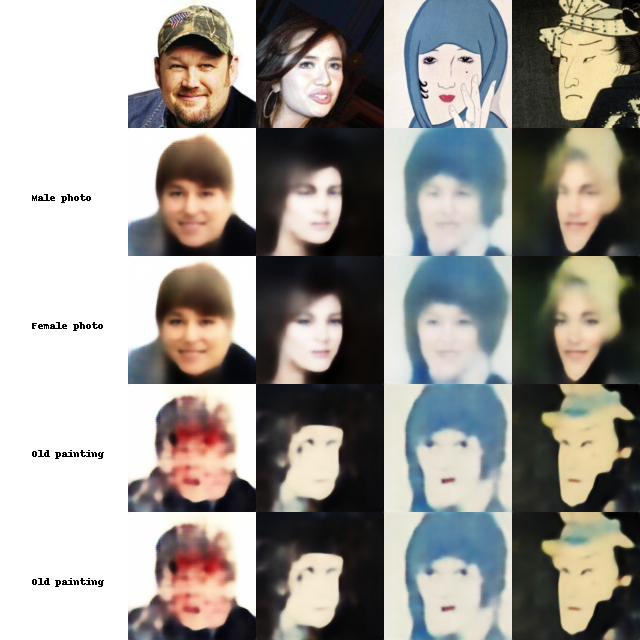

[64/1000][132/162][Time 46.25]
Unified LR across all optimizers: 0.00012331332145321206
--------------------Training Metrics--------------------
Trainer:  resnet
Inf: 0.0106	Gen: 0.1310	Rec: 0.1310	E: 0.0106	R: 0.0106	P: 0.2514


In [9]:
trainer_hub.train(celeba_ukiyoe_dataset)